# Model for predicting Fraudulent Transactions

Fraud detection is classified as an imbalanced classification problem. There is a considerable disparity between the number of fraudulent profiles/transactions and the number of non-fraudulent profiles/transactions, to be specific. As a result, utilising accuracy as an evaluation criteria will not go you very far.

Consider a dataset containing one fraudulent transaction and 99 non-fraudulent transactions to see why (in the real world, the ratio is even smaller). It would be 99 percent accurate for a machine learning model to categorise every single transaction as non-fraudulent! Unfortunately, we aren't concerned with non-fraudulent transactions, thus this accuracy-based model falls short of solving the problem.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

# Splitting Train-Test data
from sklearn.model_selection import train_test_split

# For Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import metrics

# For showing Progress Bar
from tqdm.notebook import tqdm

# Models
import optuna
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
def my_print(s):
    
    a = 4
    for i in s:
        a+=1
    return print('-' * a + '\n' + '| ' + s + ' |' + '\n' + '-' * a)

In [2]:
df = pd.read_csv('Fraud.csv')

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


There are a few transactions that have very large amounts. Also, the mean of isFraud is 0.00129, meaning we there are ~1.2 frauds per 1000 transactions.

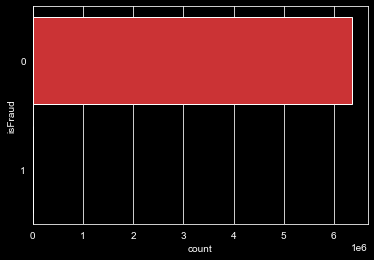

In [6]:
sns.countplot(y = df['isFraud'], palette='Set1');

The class imbalance is defined as a percentage of the total number of transactions presented in
the isFraud column.Target Variable is highly Imbalanced.

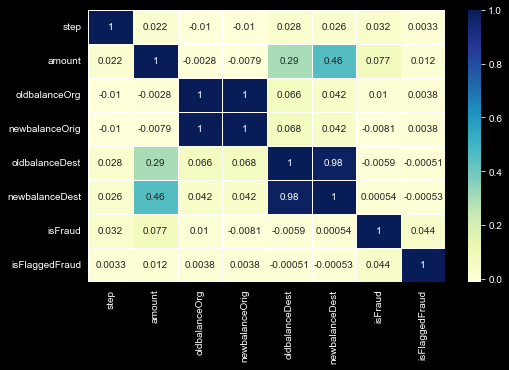

In [7]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), cmap='YlGnBu', linewidth=0.5, annot=True);

In [8]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
fraud = df[df['isFraud'] == 1]

In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Splitting Numerical and Categorical Data

In [11]:
cat = [i for i in df.drop('isFraud', axis=1).columns if df[i].dtypes == 'O']
cat

['type', 'nameOrig', 'nameDest']

In [12]:
num = [i for i in df.drop('isFraud', axis=1).columns if df[i].dtypes != 'O']
num

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud']

# Categorical Data

In [13]:
df.groupby(['type', 'isFraud']).count()['step']

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: step, dtype: int64

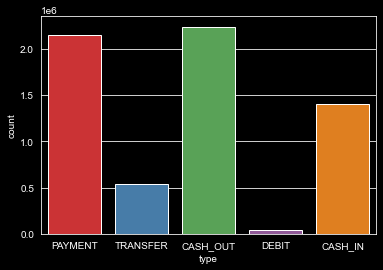

In [14]:
sns.countplot(df['type'], palette='Set1');

In [15]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                          
dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) 

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) 


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


In [16]:
df['nameOrig'].nunique(), df['nameDest'].nunique()

(6353307, 2722362)

<AxesSubplot:xlabel='step', ylabel='Density'>

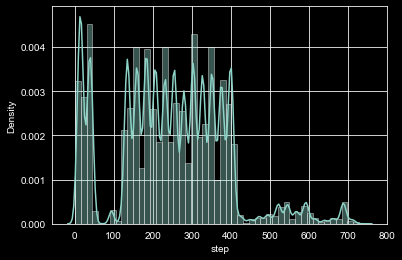

In [17]:
sns.distplot(df['step'])

<AxesSubplot:xlabel='amount', ylabel='Density'>

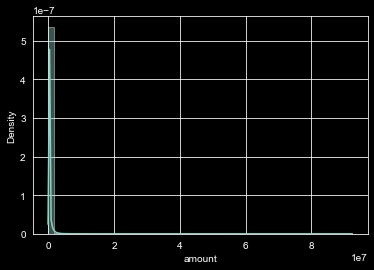

In [18]:
sns.distplot(df['amount'])

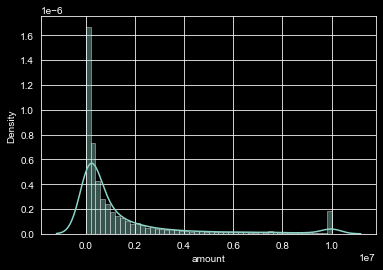

In [19]:
sns.distplot(fraud['amount']);

We can see that fraud is only when amount is low.

In [20]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [21]:
types = pd.get_dummies(df['type'], prefix='type', drop_first=True)
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


In [22]:
df['nameOrig'] = label.fit_transform(df['nameOrig'])
df['nameDest'] = label.fit_transform(df['nameDest'])

In [23]:
df[['nameOrig', 'nameDest']]

,nameOrig,nameDest
0,757869,1662094
1,2188998,1733924
2,1002156,439685
3,5828262,391696
4,3445981,828919
...,...,...
6362615,5651847,505863
6362616,1737278,260949
6362617,533958,108224
6362618,2252932,319713


In [24]:
df = pd.concat([df, types], axis=1)
df = df.drop('type', axis=1)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,1,0


# Cleaning the data

In [25]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Model selection

In [32]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [ ]:
# N_SPLITS = 2  # previous:300, increasing N_SPLITS to remove error due to randomness

lgbm_preds = []
xgb_preds = []
catb_preds = []

prob = []

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):

    my_print(f'fold {fold + 1}')

    X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
    X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]
    
    lgbm_model = lgbm.LGBMClassifier()
    xgb_model  = xgb.XGBClassifier()
    catb_model = catb.CatBoostClassifier(verbose=0)
    
    lgbm_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    catb_model.fit(X_train, y_train)
        
    my_print(f'Training Accuracy   :- {(lgbm_model.score(X_train, y_train)*100).round(2)}% | {(xgb_model.score(X_train, y_train)*100).round(2)}% | {(catb_model.score(X_train, y_train)*100).round(2)}%')
    my_print(f'Validation Accuracy :- {(lgbm_model.score(X_valid, y_valid)*100).round(2)}% | {(xgb_model.score(X_valid, y_valid)*100).round(2)}% | {(catb_model.score(X_valid, y_valid)*100).round(2)}%')
    
    prob1, prob2, prob3 = lgbm_model.predict_proba(X_test), xgb_model.predict_proba(X_test), catb_model.predict_proba(X_test)
    prob.append((prob1 + prob2 + prob3) / 3)
    my_print('Model Trained !!!')
    xgb_model  = xgb.XGBClassifier()
    X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
    weights = (y==0).sum()/(1.0 *  (y==1).sum())
    xgb_classifier1 = xgb.XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
    xgb_prediction1 = xgb_classifier1.fit(X_train, y_train).predict_proba(X_test)

    print('AUPRC = {}'.format(average_precision_score(Y_test, xgb_prediction1[:,1])))

  0%|          | 0/2 [00:00<?, ?it/s]

----------
| fold 1 |
----------


In [ ]:
final = [[0,0]]
for i in range(N_SPLITS):
    final = final + prob[i]
    
final = final/N_SPLITS
y_pred = pd.Series([np.argmax([i]) for i in final])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_print(f'Test Accuracy:- {accuracy_score(y_test, y_pred)*100}%')

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='YlGnBu', linewidths=0.5, annot=True);

# Ways to tackle 

1.One clever option for medium-sized businesses is to collaborate, with fraudulent clients' profiles and delinquent data being submitted to a pooled database that can be accessed for the greater good. For example, using solutions provided by startups and organisations that develop insights to detect frauds, corporations might assign a risk score to each profile. There are solutions to map the digital trail of identities based on a variety of parameters such as fraud history, location, and name match percentage across platforms to give a clear signal to companies on the authenticity of the identity right from the start and decide whether to onboard a client or not.

2.Additional verification, such as facial recognition or biometric data, may be necessary to improve the security provided by Machine Learning. These security solutions necessitate the use of real people to validate the activity, lowering the chances of a successful fraud.

3.For better and more accurate results, the location spoofing details, as well as knowing where the fraudster is making these purchases from, must be incorporated to the ML algorithm.

# how would you determine if these techniques work?